# Setup

In [1]:
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        c0 = fd.exp(x*y*self.t)
        
        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (10, 12)), # top-bottom and cylinder
          fd.DirichletBC(self.V['u'], ((1.0*(y - 1)*(2 - y))/(0.5**2) ,0), 9)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 11)]  # outflow
        bcc1 = [fd.DirichletBC(self.V['cd'].sub(0), c0, 'on_boundary')]

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]
        self.bc['cd'][0] = [bcc1, c0, 'on_boundary', 0, 'update']

    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'Kd' : fd.Constant(0.01),
            'k1' : fd.Constant(0.5),
            'k2' : fd.Constant(0.01),
            'lamd1' : fd.Constant(1.5),
            'lamd2' : fd.Constant(0.),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.)
        }

# Solve

In [17]:
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.0005,
'T': 1.0
}
)

#define mesh
mesh = fd.Mesh("../../../meshes/step.msh")

# add subsystems
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
#setup system and define subsystems
solver.setup_constants()
solver.define(['u', 'p', 'u'], 'up')
solver.define(['cd', 'cs', 'as'], 'cdcsas')
solver.setup_bcs()

#setup initial condition
x, y = fd.SpatialCoordinate(mesh)
c = fd.exp(x*y*solver.t)
solver.setup_initial('cd_n', c, mixedspace=True, index=0)

#solve
solver.solve(time_update=True)

{'u': [[None, None, None, None, None], [None, None, None, None, None]], 'p': [[None, None, None, None, None]]}
{'u': [[None, None, None, None, None], [None, None, None, None, None]], 'p': [[None, None, None, None, None]], 'cd': [[None, None, None, None, None], [None, None, None, None, None]], 'cs': [[None, None, None, None, None], [None, None, None, None, None]], 'as': [[None, None, None, None, None], [None, None, None, None, None]]}
[None, None, None, None, None, None, None, None, None]
u 0
p 1
u 2
cd 3
cd 4
cs 5
cs 6
as 7
as 8
time = 1.000


# Plotting

## Pressure and Velocity

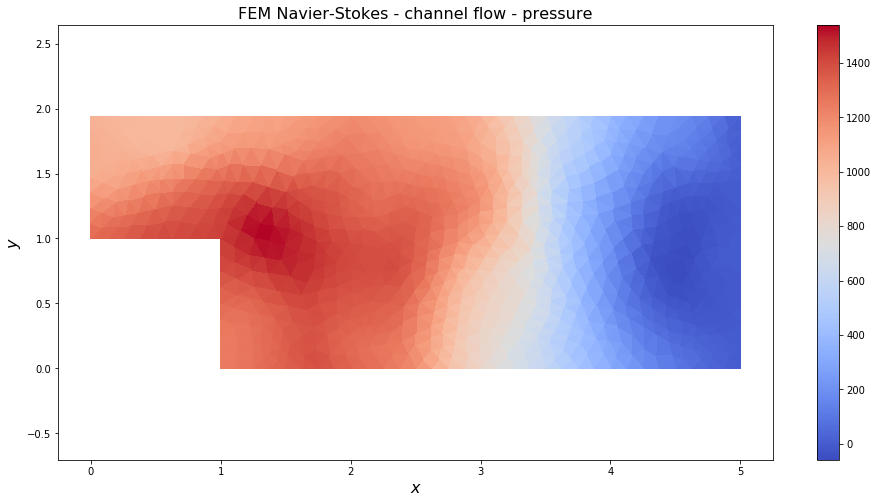

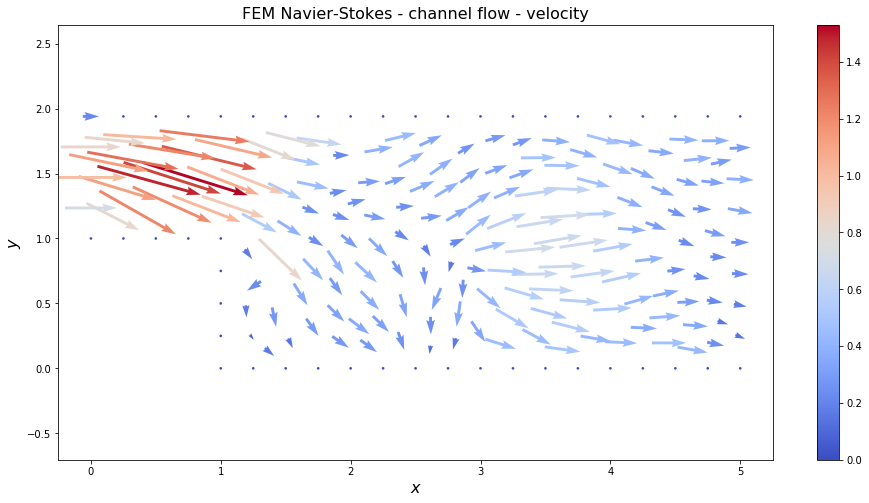

In [18]:
fig1 = plt.figure(figsize=(16, 8))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(solver.form_args['p_n'],axes=ax1)
ax1.axis('equal')

fig2 = plt.figure(figsize=(16, 8))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(solver.form_args['u_n'],axes=ax2)
ax2.axis('equal');




## Dissolved Phase

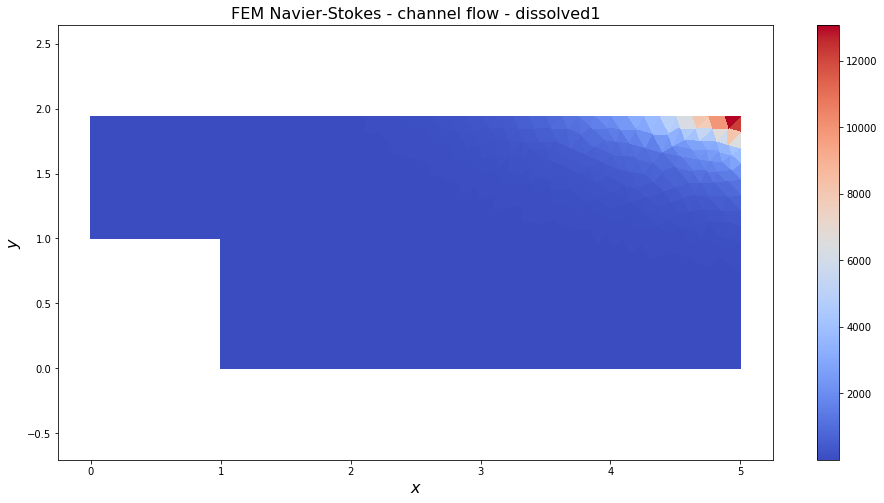

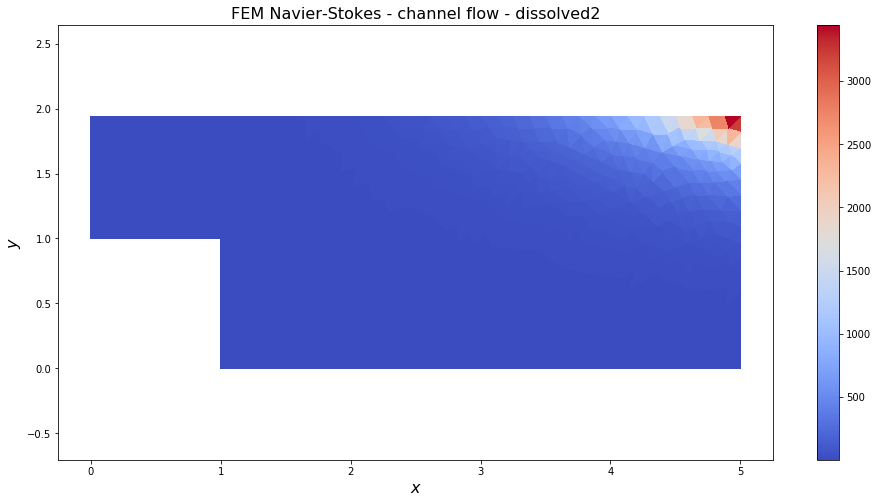

In [19]:
cd1, cd2 = solver.form_args['cd_n'].split()

fig3 = plt.figure(figsize=(16, 8))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('FEM Navier-Stokes - channel flow - dissolved1', fontsize=16)
fd.plot(cd1,axes=ax3)
ax3.axis('equal');

fig6 = plt.figure(figsize=(16, 8))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - dissolved2', fontsize=16)
fd.plot(cd2, axes=ax6)
ax6.axis('equal');

## Suspended Phase

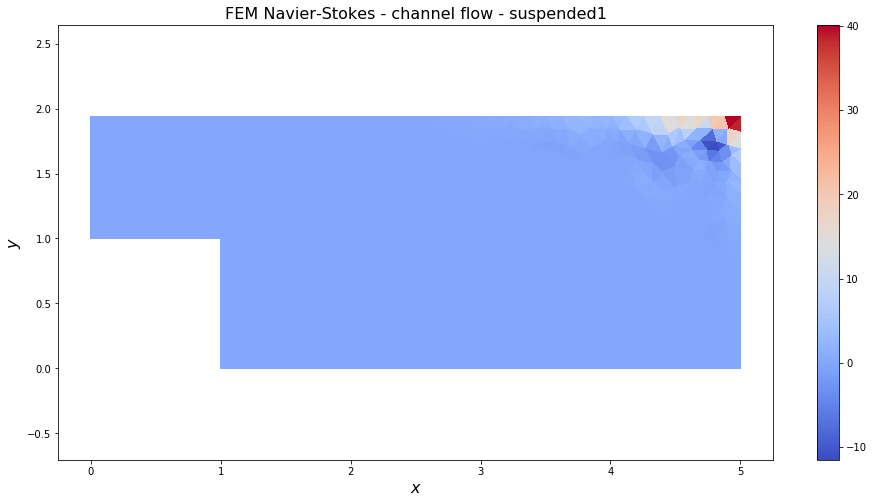

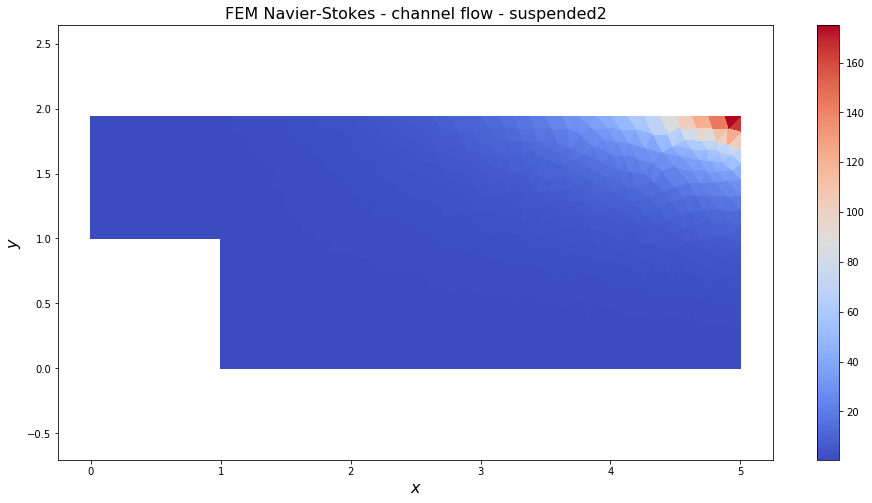

In [20]:
cs1, cs2 = solver.form_args['cs_'].split()

fig4 = plt.figure(figsize=(16, 8))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - suspended1', fontsize=16)
fd.plot(cs1, axes=ax4)
ax4.axis('equal');

fig7 = plt.figure(figsize=(16, 8))
ax7 = fig7.add_subplot(111)
ax7.set_xlabel('$x$', fontsize=16)
ax7.set_ylabel('$y$', fontsize=16)
ax7.set_title('FEM Navier-Stokes - channel flow - suspended2', fontsize=16)
fd.plot(cs2, axes=ax7)
ax7.axis('equal');

## Sediment Phase

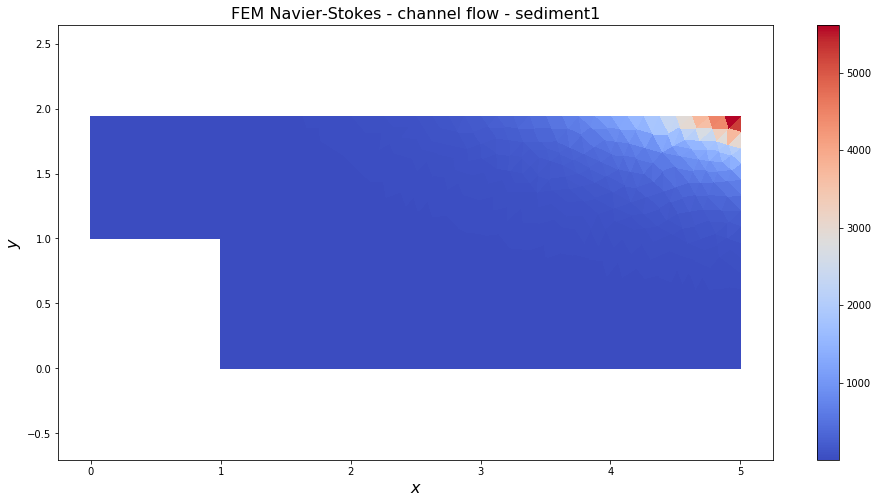

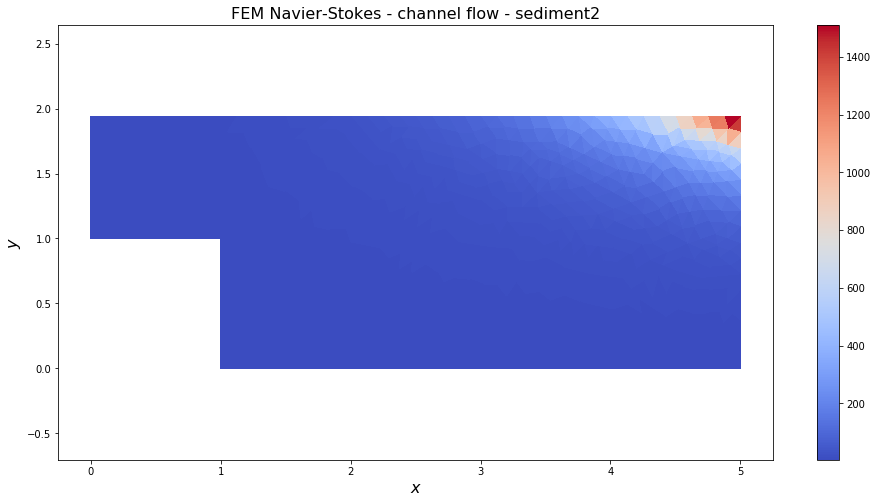

In [21]:
as1, as2 = solver.form_args['as_'].split()

fig5 = plt.figure(figsize=(16, 8))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(as1, axes=ax5)
ax5.axis('equal');

fig8 = plt.figure(figsize=(16, 8))
ax8 = fig8.add_subplot(111)
ax8.set_xlabel('$x$', fontsize=16)
ax8.set_ylabel('$y$', fontsize=16)
ax8.set_title('FEM Navier-Stokes - channel flow - sediment2', fontsize=16)
fd.plot(as2, axes=ax8)
ax8.axis('equal');

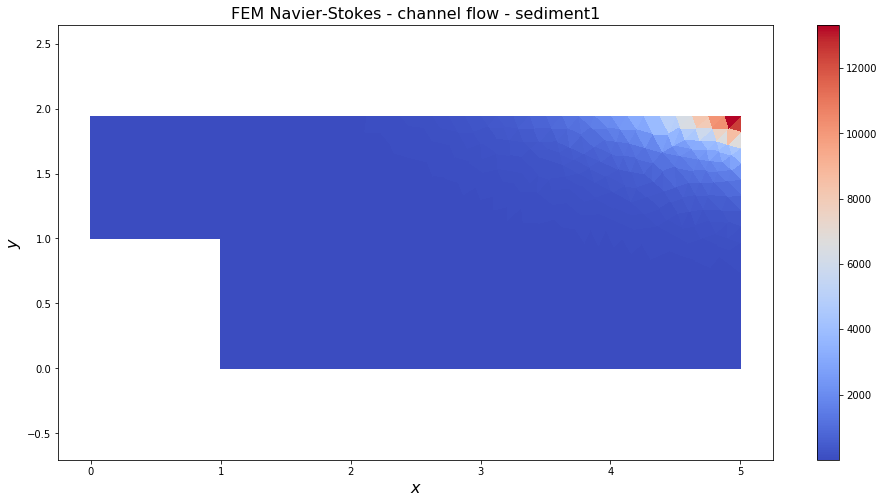

In [31]:
x, y = fd.SpatialCoordinate(solver.mesh)
c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(1)), solver.V['cd'][0])

fig9 = plt.figure(figsize=(16, 8))
ax9 = fig9.add_subplot(111)
ax9.set_xlabel('$x$', fontsize=16)
ax9.set_ylabel('$y$', fontsize=16)
ax9.set_title('FEM Navier-Stokes - channel flow - sediment1', fontsize=16)
fd.plot(c_exact, axes=ax9)
ax9.axis('equal');

In [118]:
import numpy.linalg as nl

solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : 0.001,
'T': 1.0
}
)
error_fd_norm = []
num_vertices = []
dx_array = []
error_l2 = []

for i in range(6, 11):
    mesh = fd.Mesh("../../../meshes/step%d.msh" % i)
    x, y = fd.SpatialCoordinate(mesh)
    # setup a function space to obtain the cell volumes
    DG0 = fd.FunctionSpace(mesh, 'DG', 0)
    b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
    mean = b.dat.data.mean()
    
    # add subsystems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['cd', 'cs', 'as'], 'cdcsas')
    solver.setup_bcs()

    #setup initial condition
    x, y = fd.SpatialCoordinate(mesh)
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)

    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(solver.prm['T'])), solver.V['cd'][0])
    
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    num_vertices.append(mesh.num_vertices())
    error_l2.append(nl.norm(cd1.dat.data - c_exact.dat.data) / np.sqrt(cd1.dat.data.shape))
    dx_array.append((np.sqrt(2*mean)))
    


time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000
time = 1.000


In [119]:
print(cd1.dat.data.shape)
print(error_fd_norm)
error_rms = error_fd_norm[:] / np.sqrt(num_vertices[:])
print(error_rms)
print(num_vertices)
print(error_l2)
print(dx_array)
print(c_exact.dat.data)

(583,)
[54.90015059024921, 661.0748715958895, 481.8706316329993, 258.10977042247123, 176.021709394749, 90.07305945995029]
[ 1.57436979 83.28760515 47.94791993 20.09381838  9.76392767  3.73044496]
[1216, 63, 101, 165, 325, 583]
[array([22.00030201]), array([296.87446277]), array([191.10334917]), array([106.91573535]), array([69.22421602]), array([33.92980643])]
[0.08716796014080615, 0.42573465914816, 0.32672383790851367, 0.250179791465166, 0.17350448475003089, 0.12758093232819886]
[1.00000000e+00 1.00000000e+00 1.19618223e+00 1.18515848e+00
 1.33015319e+00 1.00000000e+00 1.34062696e+00 1.56450528e+00
 1.00000000e+00 1.00000000e+00 1.12863924e+00 1.00000000e+00
 1.18468729e+00 1.13984796e+00 1.00000000e+00 1.23719668e+00
 1.12154903e+00 1.51030723e+00 1.33971597e+00 1.22712526e+00
 1.00000000e+00 1.76930751e+00 1.91711157e+00 1.38545796e+00
 1.37265579e+00 1.30938160e+00 1.15356499e+00 1.58241606e+00
 1.92301570e+00 1.57366496e+00 2.35345004e+00 2.33086932e+00
 1.52111387e+00 1.33071220e

[1.60226085 7.88286709]
[[1.6690246 ]
 [7.08465063]]


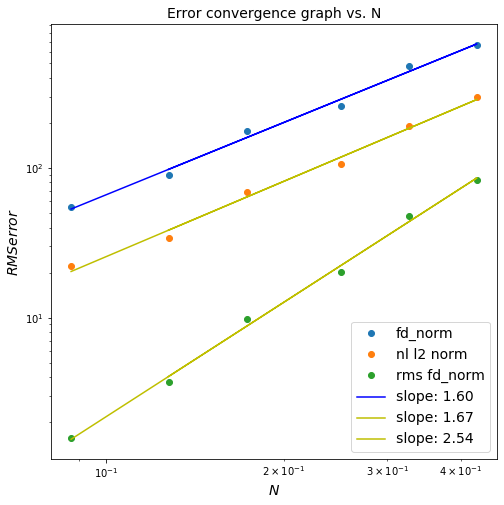

In [120]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dx_array, error_fd_norm, 'o', label='fd_norm')
ax1.loglog(dx_array, error_l2, 'o', label='nl l2 norm')
ax1.loglog(dx_array, error_rms, 'o', label='rms fd_norm')

ax1.set_xlabel('$N$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. N', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit

start_fit = 0
line_fit_uniform_fd = np.polyfit(np.log(dx_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)
line_fit_uniform_l2 = np.polyfit(np.log(dx_array[start_fit:]), np.log(error_l2[start_fit:]), 1)
line_fit_uniform_rms = np.polyfit(np.log(dx_array[start_fit:]), np.log(error_rms[start_fit:]), 1)
print(line_fit_uniform_fd)
print(line_fit_uniform_l2)

ax1.loglog(dx_array, np.exp(line_fit_uniform_fd[1]) * dx_array**(line_fit_uniform_fd[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.loglog(dx_array, np.exp(line_fit_uniform_l2[1][0]) * dx_array**(line_fit_uniform_l2[0][0]), 'y-', label = 'slope: {:.2f}'.format(line_fit_uniform_l2[0][0]))
ax1.loglog(dx_array, np.exp(line_fit_uniform_rms[1]) * dx_array**(line_fit_uniform_rms[0]), 'y-', label = 'slope: {:.2f}'.format(line_fit_uniform_rms[0]))
ax1.legend(loc='best', fontsize=14)


In [5]:
import numpy.linalg as nl

deltat = 0.01


solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'cs': fd.MixedFunctionSpace, 'cd' : fd.MixedFunctionSpace, 'as' : fd.MixedFunctionSpace},
'degree': {'u': 2, 'p': 1, 'cs': 1, 'cd' : 1, 'as' : 1},
'order' : {'u': 1, 'p': 1, 'cs' : 2, 'cd' : 2, 'as' : 2, 'cdcsas' : 2},
'linear_solver': {'u': 'gmres', 'p': 'gmres', 'cs': 'gmres', 'cd': 'gmres', 'as': 'gmres'},
'subsystem_class' : {'up': navier_stokes, 'cdcsas' : radio_transport_mms},
'precond': {'u': 'sor', 'p' : 'sor', 'cs': 'sor', 'cd': 'sor', 'as': 'sor'},
'dt' : deltat,
'T': 0.1
}
)

mesh = fd.Mesh("../../../meshes/step1.msh")
x, y = fd.SpatialCoordinate(mesh)


error_fd_norm = []
dt_array = []
error_l2 = []

for i in range(5):
    print(deltat)
    solver_parameters = recursive_update(solver_parameters, {'dt': deltat})
    # create solver and add systems
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    solver.add_subsystem(['cd', 'cs', 'as'], solver_parameters)
    #setup system and define subsystems
    solver.setup_constants()
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['cd', 'cs', 'as'], 'cdcsas')
    solver.setup_bcs()
    
    c = fd.exp(x*y*solver.t)
    solver.setup_initial('cd_n', c, mixedspace=True, index=0)
    # exact solution
    c_exact = fd.interpolate(fd.exp(x*y*fd.Constant(0.5)), solver.V['cd'][0])


    #solve
    solver.solve(time_update=True)
    cd1, cd2 = solver.form_args['cd_n'].split()
    
    # track error
    error_fd_norm.append(fd.errornorm(c_exact, cd1))
    num_vertices.append(mesh.num_vertices())
    error_l2.append(nl.norm(cd1.dat.data - c_exact.dat.data) / np.sqrt(cd1.dat.data.shape))
    
    # divide time step by 2
    deltat /= 2 
    dt_array.append(deltat)

0.01
0.005
0.0025
0.00125


[4.576651014688666, 2.5620424933896664, 1.537552537251428, 0.6523807667151029]
[0.005, 0.0025, 0.00125, 0.000625]
[array([2.48126273]), array([1.31419315]), array([0.71015419]), array([0.25513695])]
[0.91681771 6.42703493]
[[1.07331654]
 [6.67116179]]


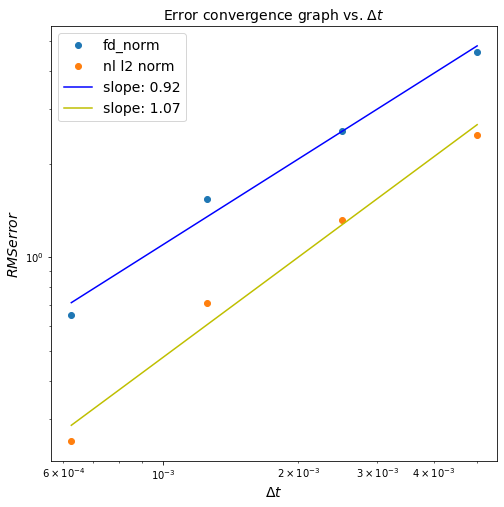

In [8]:
print(error_fd_norm)
print(dt_array)
print(error_l2)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.loglog(dt_array, error_fd_norm, 'o', label='fd_norm')
ax1.loglog(dt_array, error_l2, 'o', label='nl l2 norm')

ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('$RMS error$', fontsize=14)
ax1.set_title('Error convergence graph vs. $\Delta t$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

# line fit

start_fit = 0
line_fit_uniform_fd = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_fd_norm[start_fit:]), 1)
line_fit_uniform_l2 = np.polyfit(np.log(dt_array[start_fit:]), np.log(error_l2[start_fit:]), 1)
print(line_fit_uniform_fd)
print(line_fit_uniform_l2)

ax1.loglog(dt_array, np.exp(line_fit_uniform_fd[1]) * dt_array**(line_fit_uniform_fd[0]), 'b-', label = 'slope: {:.2f}'.format(line_fit_uniform_fd[0]))
ax1.loglog(dt_array, np.exp(line_fit_uniform_l2[1][0]) * dt_array**(line_fit_uniform_l2[0][0]), 'y-', label = 'slope: {:.2f}'.format(line_fit_uniform_l2[0][0]))
ax1.legend(loc='best', fontsize=14)


volume


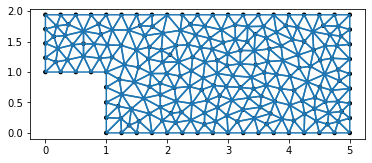

In [71]:
fd.plot(mesh)


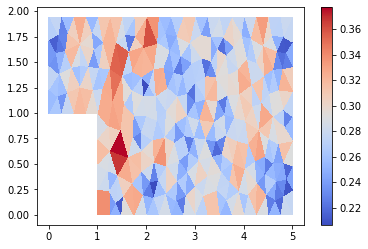

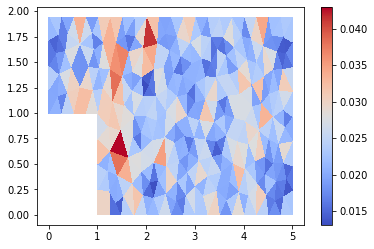

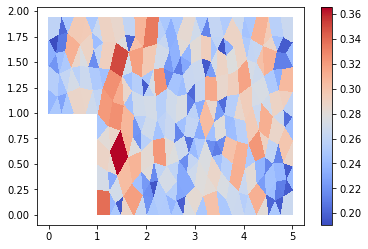

In [93]:
DG0 = fd.FunctionSpace(mesh, 'DG', 0)
a = fd.Function(DG0).interpolate(fd.CellSize(mesh))
b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
c = fd.Function(DG0).interpolate(fd.CellDiameter(mesh))
fd.plot(a)
fd.plot(b)
fd.plot(c)

In [85]:
print(a.dat.data.mean())
print(b.dat.data.mean())

0.2788558267766196
0.023138297872340424


In [96]:
fd.CellVolume?

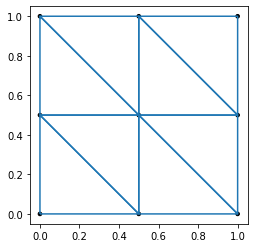

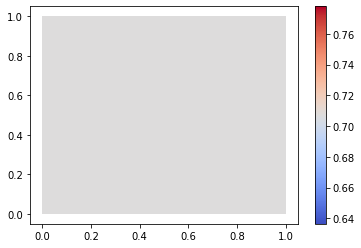

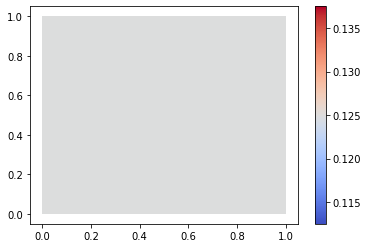

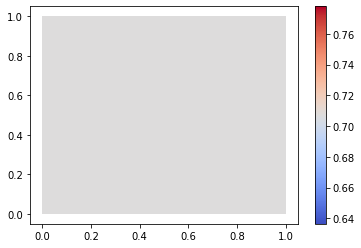

In [99]:
mesh = fd.UnitSquareMesh(2, 2)
fd.plot(mesh)
DG0 = fd.FunctionSpace(mesh, 'DG', 0)
a = fd.Function(DG0).interpolate(fd.CellSize(mesh))
b = fd.Function(DG0).interpolate(fd.CellVolume(mesh))
c = fd.Function(DG0).interpolate(fd.CellDiameter(mesh))
fd.plot(a)
fd.plot(b)
fd.plot(c)